In [1]:
from utils import *
from helpers import *
import pandas as pd
from params import *
import os

In [ ]:
# [sum(row) for i, row in enumerate(OD_MATRIX) if i not in FLEX_STOPS]

# hourly_fixed_demand = sum([sum(row) for i, row in enumerate(OD_MATRIX) if i not in FLEX_STOPS])
# hourly_flex_demand = sum([sum(row) for i, row in enumerate(OD_MATRIX) if i in FLEX_STOPS])
# pct_fixed = round(hourly_fixed_demand/(hourly_fixed_demand + hourly_flex_demand)*100, 2)
# pct_flex = round(hourly_flex_demand/(hourly_fixed_demand + hourly_flex_demand)*100, 2)
# print(f'100% demand: {hourly_fixed_demand + hourly_flex_demand}')
# print(f'Fixed demand: {hourly_fixed_demand} ({pct_fixed} %)')
# print(f'Flex demand: {hourly_flex_demand} ({pct_flex} %)')
# get_heatmap(OD_MATRIX, "OD Matrix")

In [ ]:
def plot_minimum_requests_per_delay():
    fig, axs = plt.subplots(figsize=(3, 2))
    delays = np.arange(0, 400, 5)/60
    # plot line of various slopes
    slopes = [0, 0.2, 0.5, 1.0]
    colors = ['red', 'green', 'blue', 'black']
    for slope, color in zip(slopes, colors):
        thresholds = [slope*delay for delay in delays]
        axs.plot(delays, thresholds, color=color, linestyle='dashed', label=f'slope = {slope}')
    axs.set_xlabel('Delay (minutes)')
    axs.set_ylabel('Minimum Requests')
    yticklabels = [0,2,4,6,8,10]
    axs.set_yticks(yticklabels)
    axs.legend()
    axs.grid()

plot_minimum_requests_per_delay()

### all scenarios

In [2]:
def read_results(results_path):
    time_bucket = 30*60
    idle = pd.read_csv(os.path.join(results_path, 'idle.csv'))
    pax = pd.read_csv(os.path.join(results_path, 'pax.csv'))
    pax['bucket'] = pax['arrival_time'] // time_bucket
    state = pd.read_csv(os.path.join(results_path, 'state.csv'))
    trips = pd.read_csv(os.path.join(results_path, 'vehicles.csv'))
    trips['delay'] = trips['arrival_time'] - trips['scheduled_time']
    trips['bucket'] = trips['arrival_time'] // time_bucket
    create_field_from_list_column(state, 3, 'delay')
    create_field_from_list_column(state, 1, 'n_requests')
    create_field_from_list_column(state, 0, 'lost_requests', field_name='unweighted_rewards')
    create_field_from_list_column(state, 1, 'off_schedule_trips', field_name='unweighted_rewards')
    return idle, pax, state, trips


def tabulate_improvements(results_path, on_time_bounds: list, base_scenario: str = 'ND',
                          flex_stops: list = [], start_time: int = 0, 
                          end_time: int = 10000) -> tuple:
    idle, pax, state, trips = read_results(results_path)
    # Filter DataFrames to the specified time range
    idle = idle[(idle['time'] >= start_time) & (idle['time'] <= end_time)]
    pax = pax[(pax['arrival_time'] >= start_time) & (pax['arrival_time'] <= end_time)]
    trips = trips[(trips['arrival_time'] >= start_time) & (trips['arrival_time'] <= end_time)]
    state = state[(state['time'] >= start_time) & (state['time'] <= end_time)]

    # Group and aggregate results for each DataFrame
    n_denied = pax[pax['boarding_time'].isna()].groupby(['scenario']).size()
    idle_sum = (idle.groupby(['scenario'])['idle_time'].sum()/60/60).round(2)
    wait_time_mean = pax.groupby(['scenario'])['wait_time'].mean().round(0)
    fixed_trip_stops = trips[~trips['stop'].isin(flex_stops)]
    headway_cv = (fixed_trip_stops.groupby(['scenario'])['headway'].std() / fixed_trip_stops.groupby(['scenario'])['headway'].mean()).round(3)
    avg_load = trips.groupby(['scenario'])['load'].mean().round(2)
    n_fixed_pax = pax[(~pax['origin'].isin(flex_stops)) & (pax['boarding_time'].notna())].groupby(['scenario']).size()
    n_flex_pax = pax[(pax['origin'].isin(flex_stops)) & (pax['boarding_time'].notna())].groupby(['scenario']).size()
    n_tot_pax = pax[pax['boarding_time'].notna()].groupby(['scenario']).size()
    n_trips = trips[trips['stop']==0].groupby(['scenario']).size()
    on_time_trips = trips[(trips['delay'].between(*on_time_bounds)) & (trips['stop']==0)].groupby(['scenario']).size()
    trips['delay'] = trips['arrival_time'] - trips['scheduled_time']
    average_delay_by_group = trips[~trips['stop'].isin(flex_stops)].groupby('scenario')['delay'].mean().round(0)
    n_deviations = state.groupby(['scenario'])['action'].sum()
    avg_reward = state.groupby(['scenario'])['reward'].mean().round(3)
    avg_episode_reward = state.groupby(['scenario', 'episode'])['reward'].sum()
    avg_episode_reward = avg_episode_reward.groupby('scenario').mean().round(3)

    # Create a DataFrame with all the metrics
    result_df = pd.DataFrame({
        'idle_time': idle_sum,
        'wait_time': wait_time_mean,
        'headway_cv': headway_cv,
        'load': avg_load,
        'n_denied_riders': n_denied,
        'fixed_ridership': n_fixed_pax,
        'flex_ridership': n_flex_pax,
        'tot_ridership': n_tot_pax,
        'n_trips': n_trips,
        'on_time_trips': on_time_trips,
        'avg_delay': average_delay_by_group,
        'n_deviations': n_deviations,
        'avg_reward': avg_reward,
        'avg_episode_reward': avg_episode_reward
    })
    result_df['on_time_rate'] = (result_df['on_time_trips'] / result_df['n_trips'] * 100).round(2)
    result_df['served_rate'] = 100 - result_df['n_denied_riders'] / (result_df['n_denied_riders']+result_df['flex_ridership']) * 100
    result_df['served_rate'] = result_df['served_rate'].fillna(0.0).round(2)
    # Calculate percentage change from the base scenario
    pct_change_df = result_df.copy()
    for col in result_df.columns:
        base_value = result_df.loc[base_scenario, col]
        pct_change_df[col] = ((result_df[col] - base_value) / base_value * 100).round(3)
    
    # Return the result DataFrame
    return result_df, pct_change_df

In [83]:
tstamp = '0305-150701'
RESULTS_PATH = os.path.join(OUTPUT_FOLDER_PATH,'experiments_'+tstamp)
table, table_pcts = tabulate_improvements(RESULTS_PATH, ON_TIME_BOUNDS, base_scenario='DRD_30', 
                                          flex_stops=FLEX_STOPS, start_time=RESULTS_START_TIME_MINUTES*60, 
                                          end_time=RESULTS_END_TIME_MINUTES*60)

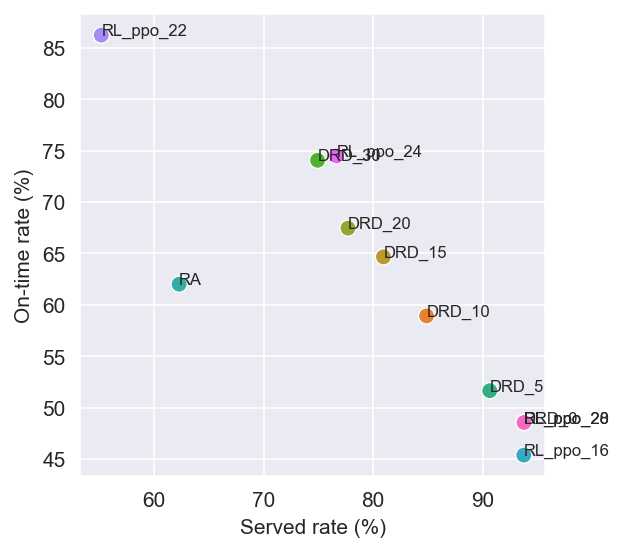

In [20]:
fig, axs = plt.subplots(figsize=(4,4))
## make background of axis dark
sns.set_style("darkgrid")
sns.scatterplot(data=table, x='served_rate', y='on_time_rate', hue='scenario', ax=axs, s=60)
axs.set_xlabel('Served rate (%)')
axs.set_ylabel('On-time rate (%)')
axs.legend().remove()

## add legend labels to dots
for i, txt in enumerate(table.index):
    axs.annotate(txt, (table['served_rate'][i], table['on_time_rate'][i]), fontsize=8)

In [92]:
table[['avg_episode_reward', 'on_time_rate', 'served_rate', 'n_denied_riders', 'flex_ridership', 'tot_ridership', 'n_trips']]

,avg_episode_reward,on_time_rate,served_rate,n_denied_riders,flex_ridership,tot_ridership,n_trips
scenario,,,,,,,
DRD_0,-33.88,48.55,93.74,70,1048,5777,760
DRD_10,-37.00,58.92,84.86,164,919,5731,762
DRD_15,-37.32,64.66,80.93,208,883,5624,764
DRD_20,-38.92,67.45,77.70,244,850,5625,762
DRD_30,-38.00,74.05,74.93,277,828,5617,767
DRD_5,-36.64,51.64,90.62,102,985,5745,761
RA,-57.48,62.00,62.31,412,681,5308,771
RL_ppo_16,-35.52,45.38,93.72,72,1074,5795,758
RL_ppo_20,-33.88,48.55,93.74,70,1048,5777,760


In [87]:
episodes = [2, 7]
scenario = 'DRD_0'

state = pd.read_csv(os.path.join(RESULTS_PATH, 'state.csv'))
state = state[(state['scenario']==scenario) & (state['episode'].isin(episodes))]
vehicles = pd.read_csv(os.path.join(RESULTS_PATH, 'vehicles.csv'))
vehicles = vehicles[(vehicles['scenario']==scenario) & (vehicles['episode'].isin(episodes))]
vehicles['schedule_deviation'] = vehicles['arrival_time'] - vehicles['scheduled_time']
vehicles['dwell_time'] = vehicles['departure_time'] - vehicles['arrival_time']

# focus on fixed
vehicles_fixed = vehicles[vehicles['flex']==0].copy()

In [88]:
state[state['episode']==7].sort_values(['veh_idx', 'time'])

,time,observation,action,reward,unweighted_rewards,veh_idx,scenario,episode
1140,1375.0,"[0, 1, 661.0, 11.0]",1,-2.0,"[1, 1]",0,DRD_0,7
1141,1994.0,"[2, 1, 499.0, 30.0]",1,-1.0,"[0, 1]",0,DRD_0,7
1142,2612.0,"[0, 4, 483.0, 50.0]",1,-6.0,"[3, 3]",0,DRD_0,7
1143,4322.0,"[2, 4, 73.0, -36.0]",1,-3.0,"[1, 2]",0,DRD_0,7
1144,5645.0,"[3, 1, 39.0, -63.0]",1,-1.0,"[0, 1]",0,DRD_0,7
1145,6058.0,"[0, 4, 1081.0, 492.0]",1,-5.0,"[4, 1]",0,DRD_0,7
1146,6691.0,"[2, 1, 56.0, -69.0]",1,0.0,"[0, 0]",0,DRD_0,7
1147,6850.0,"[3, 2, 24.0, -50.0]",1,-2.0,"[1, 1]",0,DRD_0,7
1148,7323.0,"[0, 2, 16.0, 573.0]",1,-6.0,"[4, 2]",0,DRD_0,7
1149,8518.0,"[0, 2, 75.0, -32.0]",1,-4.0,"[3, 1]",0,DRD_0,7


In [90]:
vehicles[(vehicles['veh_idx']==1) & (vehicles['arrival_time'].between(2000,5400)) & (vehicles['episode']==7)].head(60)

,direction,trip_id,stop,arrival_time,departure_time,load,boardings,alightings,scheduled_time,veh_idx,headway,flex,scenario,episode,schedule_deviation,dwell_time
6479,out,3,1,2117.0,2131.0,5,4,0,1950,1,756.0,0,DRD_0,7,167.0,14.0
6480,out,3,2,2241.0,2249.0,6,1,0,2025,1,778.0,1,DRD_0,7,216.0,8.0
6481,out,3,3,2316.0,2348.0,15,11,2,2100,1,778.0,0,DRD_0,7,216.0,32.0
6482,out,3,5,2446.0,2460.0,13,1,3,2250,1,760.0,0,DRD_0,7,196.0,14.0
6483,out,3,6,2658.0,2690.0,0,0,13,2400,1,833.0,0,DRD_0,7,258.0,32.0
6484,in,3,0,2690.0,2704.0,4,4,0,2400,1,855.0,0,DRD_0,7,290.0,14.0
6485,in,3,1,2872.0,2886.0,6,3,1,2550,1,892.0,0,DRD_0,7,322.0,14.0
6486,in,3,2,2966.0,2976.0,8,2,0,2625,1,885.0,1,DRD_0,7,341.0,10.0
6487,in,3,3,3063.0,3075.0,9,2,1,2700,1,870.0,0,DRD_0,7,363.0,12.0
6488,in,3,4,3145.0,3155.0,11,2,0,2775,1,1440.0,1,DRD_0,7,370.0,10.0


In [80]:
vehicles[(vehicles['veh_id']==0) & (vehicles['arrival_time'].between(2000,5400)) & (vehicles['episode']==7)].head(60)

,direction,trip_id,stop,arrival_time,departure_time,load,boardings,alightings,scheduled_time,veh_id,headway,flex,scenario,episode,schedule_deviation,dwell_time
6377,in,2,2,2081.0,2089.0,5,1,0,2025,0,NaN,1,DRD_0,7,56.0,8.0
6378,in,2,3,2193.0,2205.0,4,1,2,2100,0,585.0,0,DRD_0,7,93.0,12.0
6379,in,2,5,2312.0,2322.0,2,0,2,2250,0,522.0,0,DRD_0,7,62.0,10.0
6380,in,2,6,2469.0,2479.0,0,0,2,2400,0,580.0,0,DRD_0,7,69.0,10.0
6381,out,4,0,2479.0,2479.0,0,0,0,2400,0,574.0,0,DRD_0,7,79.0,0.0
6382,out,4,1,2600.0,2612.0,3,3,0,2550,0,483.0,0,DRD_0,7,50.0,12.0
6383,out,4,2,2695.0,2709.0,7,4,0,2625,0,454.0,1,DRD_0,7,70.0,14.0
6384,out,4,3,2752.0,2760.0,6,0,1,2700,0,436.0,0,DRD_0,7,52.0,8.0
6385,out,4,5,2863.0,2875.0,5,1,2,2850,0,417.0,0,DRD_0,7,13.0,12.0
6386,out,4,6,2967.0,2983.0,0,0,5,3000,0,309.0,0,DRD_0,7,-33.0,16.0


In [57]:
state.groupby('episode').size()

episode
2    27
7    32
dtype: int64

In [55]:
vehicles_fixed

,direction,trip_id,stop,arrival_time,departure_time,load,boardings,alightings,scheduled_time,veh_id,headway,flex,scenario,episode,schedule_deviation,dwell_time
5318,out,0,0,0.0,0.0,0,0,0,0,0,NaN,0,DRD_0,2,0.0,0.0
5319,out,0,1,80.0,80.0,0,0,0,150,0,NaN,0,DRD_0,2,-70.0,0.0
5320,out,0,3,258.0,258.0,0,0,0,300,0,NaN,0,DRD_0,2,-42.0,0.0
5321,out,0,5,332.0,340.0,1,1,0,450,0,NaN,0,DRD_0,2,-118.0,8.0
5322,out,0,6,420.0,428.0,0,0,1,600,0,NaN,0,DRD_0,2,-180.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6557,in,16,1,10350.0,10350.0,2,0,0,10350,1,85.0,0,DRD_0,7,0.0,0.0
6559,in,16,3,10496.0,10506.0,1,0,2,10500,1,43.0,0,DRD_0,7,-4.0,10.0
6561,in,16,5,10653.0,10653.0,1,0,0,10650,1,49.0,0,DRD_0,7,3.0,0.0
6562,in,16,6,10782.0,10790.0,0,0,1,10800,1,61.0,0,DRD_0,7,-18.0,8.0


In [45]:
vehicles.groupby('episode')['schedule_deviation'].mean().round(0)

episode
2     12.0
7    194.0
Name: schedule_deviation, dtype: float64

<AxesSubplot: xlabel='episode', ylabel='dwell_time'>

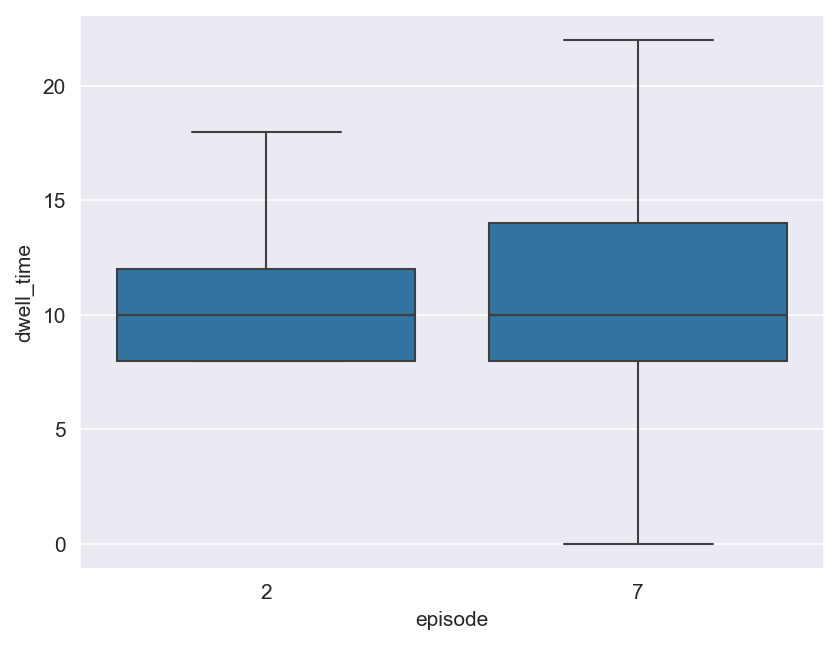

In [49]:
sns.boxplot(data=vehicles, x='episode', y='dwell_time', showfliers=False)

<AxesSubplot: xlabel='episode', ylabel='schedule_deviation'>

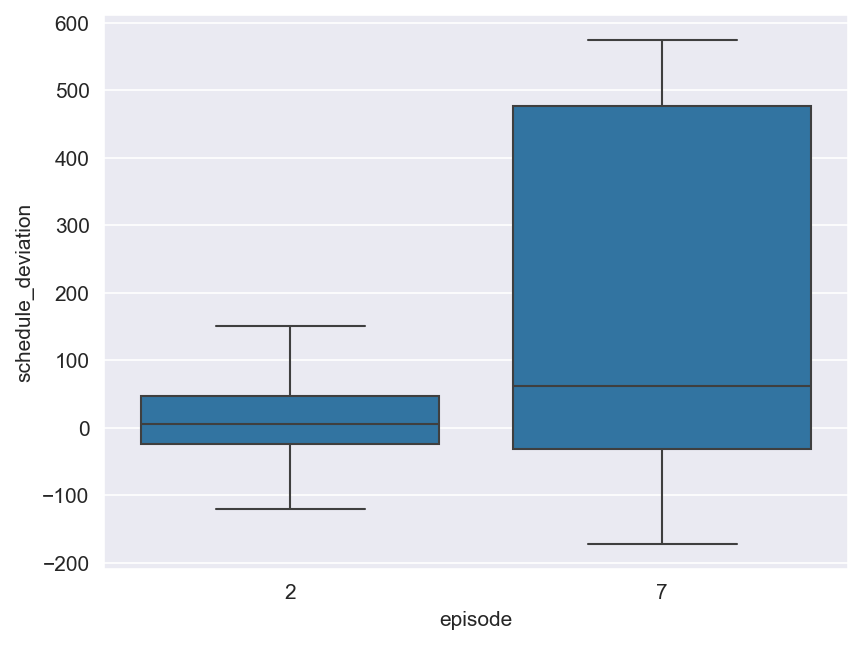

In [47]:
sns.boxplot(data=vehicles, x='episode', y='schedule_deviation', showfliers=False)

In [42]:
vehicles.groupby(['episode'])['boardings'].sum()

episode
2    247
7    284
Name: boardings, dtype: int64

In [46]:
vehicles[vehicles['flex']==1].groupby(['episode'])['boardings'].sum()

episode
2    49
7    43
Name: boardings, dtype: int64

In [ ]:
vehicles['']

,direction,trip_id,stop,arrival_time,departure_time,load,boardings,alightings,scheduled_time,veh_id,headway,flex,scenario,episode
5318,out,0,0,0.0,0.0,0,0,0,0,0,NaN,0,DRD_0,2
5319,out,0,1,80.0,80.0,0,0,0,150,0,NaN,0,DRD_0,2
5320,out,0,3,258.0,258.0,0,0,0,300,0,NaN,0,DRD_0,2
5321,out,0,5,332.0,340.0,1,1,0,450,0,NaN,0,DRD_0,2
5322,out,0,6,420.0,428.0,0,0,1,600,0,NaN,0,DRD_0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6559,in,16,3,10496.0,10506.0,1,0,2,10500,1,43.0,0,DRD_0,7
6560,in,16,4,10585.0,10585.0,1,0,0,10575,1,58.0,1,DRD_0,7
6561,in,16,5,10653.0,10653.0,1,0,0,10650,1,49.0,0,DRD_0,7
6562,in,16,6,10782.0,10790.0,0,0,1,10800,1,61.0,0,DRD_0,7


In [ ]:
state.group

In [32]:
state

,time,veh_idx,observation,action,reward,unweighted_rewards,scenario,episode
955,1347.0,1,"[2, 2, 637.0, -21.0]",1,0.0,"[0, 0]",DRD_0,0
956,1923.0,0,"[0, 1, 569.0, -27.0]",1,0.0,"[0, 0]",DRD_0,0
957,1931.0,0,"[2, 1, 592.0, -29.0]",1,0.0,"[0, 0]",DRD_0,0
958,2592.0,0,"[0, 2, 655.0, 28.0]",1,0.0,"[0, 0]",DRD_0,0
959,3163.0,1,"[2, 1, 651.0, -5.0]",1,0.0,"[0, 0]",DRD_0,0
...,...,...,...,...,...,...,...,...
1768,9893.0,0,"[3, 1, 532.0, -17.0]",1,0.0,"[0, 0]",DRD_0,24
1769,9953.0,1,"[1, 3, 680.0, 35.0]",1,-2.0,"[0, 2]",DRD_0,24
1770,10396.0,0,"[0, 1, 615.0, 28.0]",1,-2.0,"[0, 2]",DRD_0,24
1771,10491.0,0,"[2, 1, 768.0, 119.0]",1,0.0,"[0, 0]",DRD_0,24


In [28]:
rewards_per_scenario = state.groupby(['episode', 'scenario'])['reward'].sum().reset_index()

In [30]:
rewards_per_scenario[rewards_per_scenario['scenario'].isin(['DRD_0', 'RL_ppo_28'])]

,episode,scenario,reward
0,0,DRD_0,-28.0
11,0,RL_ppo_28,-28.0
12,1,DRD_0,-20.0
23,1,RL_ppo_28,-20.0
24,2,DRD_0,-18.0
35,2,RL_ppo_28,-18.0
36,3,DRD_0,-43.0
47,3,RL_ppo_28,-43.0
48,4,DRD_0,-18.0
59,4,RL_ppo_28,-18.0


In [ ]:
from stable_baselines3 import PPO

In [ ]:
# RL agent
models = ['ppo_16', 'ppo_20', 'ppo_22','ppo_24', 'ppo_28']
model = PPO.load('models/ppo_20.zip')

In [ ]:
# Use the loaded agent to predict the action based on current observation
action, _ = model.predict(observation, deterministic=True)

In [8]:
state = pd.read_csv(os.path.join(RESULTS_PATH, 'state.csv'))

In [12]:
state.head(20)

,time,veh_idx,observation,action,reward,unweighted_rewards,scenario,episode
0,760.0,0,"[0, 1, 636.0, -4.0]",1,-4.0,"[3, 1]",RA,0
1,1334.0,1,"[0, 2, 576.0, -28.0]",0,-3.0,"[2, 1]",RA,0
2,1612.0,0,"[3, 2, 748.0, 96.0]",1,-1.0,"[1, 0]",RA,0
3,1913.0,1,"[2, 3, 459.0, -47.0]",0,-6.0,"[5, 1]",RA,0
4,2283.0,0,"[1, 2, 836.0, 171.0]",0,-9.0,"[7, 2]",RA,0
5,2617.0,1,"[1, 1, 336.0, -93.0]",0,-4.0,"[3, 1]",RA,0
6,2876.0,0,"[3, 1, 765.0, 152.0]",1,-1.0,"[1, 0]",RA,0
7,3124.0,1,"[2, 3, 417.0, -26.0]",1,-3.0,"[2, 1]",RA,0
8,3406.0,1,"[0, 1, 874.0, 236.0]",0,0.0,"[0, 0]",RA,0
9,3578.0,0,"[1, 1, 957.0, 264.0]",1,-3.0,"[2, 1]",RA,0


In [ ]:
# idle_for_plot = idle.copy()
# idle_for_plot['idle_time'] = idle_for_plot['idle_time']/60/60
# idle_for_plot['time'] = idle_for_plot['time']/60/60
# plot_cumulative_idle_time(idle_for_plot)

# def plot_avg_reward_per_scenario(rewards_per_scenario: pd.Series, axs):
#     # Sort by average reward
#     rewards_per_scenario = rewards_per_scenario.sort_values(by='scenario')
#     sns.boxplot(x='total_w_reward', y='scenario', data=rewards_per_scenario, ax=axs)

# def get_avg_weighted_rewards(rewards_per_step: pd.DataFrame, weights: list,
#                              reward_fields: list):
#     rewards = rewards_per_step.copy()
#     rewards['total_w_reward'] = 0
#     for i, field in enumerate(reward_fields):
#         rewards['total_w_reward'] -= rewards[field] * weights[i]
#     episode_reward = rewards.groupby(['scenario', 'episode'])['total_w_reward'].sum().reset_index()
#     # episode_reward = episode_reward.groupby(['scenario']).mean()
#     return episode_reward

# def plot_reward_weights_comparison(state: pd.DataFrame, weights_set: list):
#     width_per_ax = 2.7
#     height = 2.3
#     n_weights = len(weights_set)
#     fig, axs = plt.subplots(ncols=n_weights, figsize=(n_weights*width_per_ax, height))
#     reward_fields = ['denied', 'early', 'late']
#     tmp_state = state[['scenario', 'episode'] + reward_fields].copy()
#     for i, weights in enumerate(weights_set):
#         tmp_rew = get_avg_weighted_rewards(tmp_state, weights, reward_fields)
#         if n_weights > 1:
#             plot_avg_reward_per_scenario(tmp_rew, axs[i])
#             axs[i].set_title(f'Weights: {weights}')
#         else:
#             plot_avg_reward_per_scenario(tmp_rew, axs)
#             axs.set_title(f'Weights: {weights}')

# weights = [[1.0,1.0,1.0], [1.0,1.0,2.0], [1.0,2.5,2.5], [1.0,1.0,2.5]]
# plot_reward_weights_comparison(state, weights)

## debugging

In [1]:
from objects import RouteManager, EventManager

route = RouteManager()
event = EventManager()
event.start_vehicles(route)
route.load_all_pax()

obs, reward, terminated, truncated, info = event.step(route, action=None)
# while not terminated:
#     obs, reward, terminated, truncated, info = event.step(route, action=True)

In [ ]:
event.timestamps[-1]

In [ ]:
pax.groupby(['origin', 'destination']).size().reset_index()

In [ ]:
for direction in ('in', 'out'):
    for s in route.stops[direction]:
        if s.active_pax:
            print([(direction, p.origin, p.destination, p.arrival_time) for p in s.active_pax])